In [1]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 59kB/s 
     |████████████████████████████████| 419kB 50.2MB/s 
     |████████████████████████████████| 3.0MB 37.9MB/s 


In [2]:
!pip install imgaug

In [0]:
import tensorflow as tf

In [4]:
tf.__version__

'2.0.0-alpha0'

In [5]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers
from tensorflow.python.keras.utils.data_utils import Sequence

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

from keras.preprocessing import image

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import PIL
import pathlib
import pandas as pd
import cv2
from imgaug import augmenters as iaa
import imgaug as ia

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import itertools

Using TensorFlow backend.


## Dataset

In [6]:
!wget https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip

--2019-06-13 23:13:50--  https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3380245855 (3.1G) [application/zip]
Saving to: ‘MURA-v1.1.zip’

MURA-v1.1.zip       100%[===================>]   3.15G  14.0MB/s    in 4m 10s  

2019-06-13 23:18:00 (12.9 MB/s) - ‘MURA-v1.1.zip’ saved [3380245855/3380245855]



In [0]:
!unzip -q MURA-v1.1.zip

In [0]:
train_paths = pd.read_csv("MURA-v1.1/train_image_paths.csv")

In [0]:
images_classes = []
images_categories = []
images_paths = []

In [0]:
for _, row in train_paths.iterrows():
  image_path = row[0]
  image_class = image_path.split("/")[4].split("_")[1]
  image_category = image_path.split("/")[2]
  
  images_paths.append(image_path)
  images_classes.append(image_class)
  images_categories.append(image_category)

In [0]:
training_information = pd.DataFrame({'path': images_paths, 
                                     'class': images_classes, 
                                     'category': images_categories})

In [0]:
training_information["class"].size

36807

In [0]:
training_information.to_csv("train_information.csv")

In [0]:
training_information = pd.read_csv("train_information.csv")

In [12]:
training_information.groupby("class").size()

class
negative    21935
positive    14872
dtype: int64

In [13]:
training_information.groupby("class").size() / training_information["class"].size * 100

class
negative    59.594642
positive    40.405358
dtype: float64

In [0]:
training_information.groupby("category").size()

category
XR_ELBOW       4931
XR_FINGER      5106
XR_FOREARM     1825
XR_HAND        5543
XR_HUMERUS     1272
XR_SHOULDER    8378
XR_WRIST       9752
dtype: int64

In [0]:
training_information.groupby("category").size() / training_information["category"].size * 100

category
XR_ELBOW       13.396908
XR_FINGER      13.872361
XR_FOREARM      4.958296
XR_HAND        15.059635
XR_HUMERUS      3.455864
XR_SHOULDER    22.761975
XR_WRIST       26.494960
dtype: float64

In [0]:
valid_paths = pd.read_csv("MURA-v1.1/valid_image_paths.csv")

In [0]:
images_classes = []
images_categories = []
images_paths = []

In [0]:
for _, row in valid_paths.iterrows():
  image_path = row[0]
  image_class = image_path.split("/")[4].split("_")[1]
  image_category = image_path.split("/")[2]
  
  images_paths.append(image_path)
  images_classes.append(image_class)
  images_categories.append(image_category)

In [0]:
valid_information = pd.DataFrame({'path': images_paths, 
                                     'class': images_classes, 
                                     'category': images_categories})

In [0]:
valid_information.to_csv("valid_information.csv")

In [0]:
valid_information = pd.read_csv("valid_information.csv")

In [16]:
valid_information["class"].size

3196

In [17]:
valid_information.groupby("class").size()

class
negative    1667
positive    1529
dtype: int64

In [18]:
valid_information.groupby("class").size() / valid_information["class"].size * 100

class
negative    52.158949
positive    47.841051
dtype: float64

In [0]:
valid_information.groupby("category").size()

category
XR_ELBOW       465
XR_FINGER      461
XR_FOREARM     301
XR_HAND        460
XR_HUMERUS     288
XR_SHOULDER    563
XR_WRIST       658
dtype: int64

In [0]:
valid_information.groupby("category").size() / valid_information["category"].size * 100

category
XR_ELBOW       14.549437
XR_FINGER      14.424280
XR_FOREARM      9.418023
XR_HAND        14.392991
XR_HUMERUS      9.011264
XR_SHOULDER    17.615770
XR_WRIST       20.588235
dtype: float64

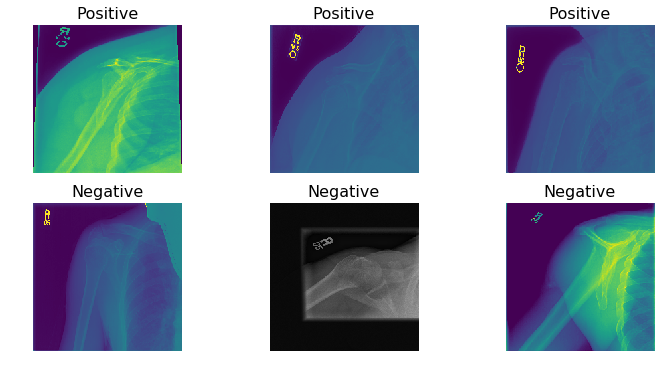

In [0]:
positive_images = training_information[training_information["class"] == "positive"]["path"][0:3]
negative_images = training_information[training_information["class"] == "negative"]["path"][0:3]

def plot_images(image_index, image_path, title):
  sp = figure.add_subplot(2, 3, image_index + 1)
  sp.axis('Off')
 
  image_loaded = PIL.Image.open(image_path)
  
  image_loaded = image_loaded.resize((224, 224))
  image_loaded = np.asarray(image_loaded)
  
  sp.set_title(title, fontsize=16)
  plt.imshow(image_loaded)

figure = plt.figure(figsize=(12, 6))

for image_index, image_path in enumerate(positive_images):
  plot_images(image_index, image_path, "Positive")

for image_index, image_path in enumerate(negative_images):
  plot_images(image_index + 3, image_path, "Negative")

In [0]:
total_information = pd.concat([training_information, valid_information])

In [0]:
total_information.head()

,Unnamed: 0,path,class,category
0,0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER
1,1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER
2,2,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER
3,3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER
4,4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER


In [0]:
total_information["class"].count()

40003

In [0]:
total_information.groupby("class").size() / total_information["class"].size * 100

class
negative    59.000575
positive    40.999425
dtype: float64

In [0]:
total_information.groupby("category").size()

category
XR_ELBOW        5396
XR_FINGER       5567
XR_FOREARM      2126
XR_HAND         6003
XR_HUMERUS      1560
XR_SHOULDER     8941
XR_WRIST       10410
dtype: int64

In [0]:
total_information.groupby(["category", "class"]).size()

category     class   
XR_ELBOW     negative    3160
             positive    2236
XR_FINGER    negative    3352
             positive    2215
XR_FOREARM   negative    1314
             positive     812
XR_HAND      negative    4330
             positive    1673
XR_HUMERUS   negative     821
             positive     739
XR_SHOULDER  negative    4496
             positive    4445
XR_WRIST     negative    6129
             positive    4281
dtype: int64

In [0]:
training_information = training_information.drop(training_information.index[training_information["category"] == "XR_HUMERUS"])
training_information = training_information.drop(training_information.index[training_information["category"] == "XR_FOREARM"])

valid_information = valid_information.drop(valid_information.index[valid_information["category"] == "XR_HUMERUS"])
valid_information = valid_information.drop(valid_information.index[valid_information["category"] == "XR_FOREARM"])

In [0]:
training_information["class"].size

33710

In [0]:
valid_information["class"].size

2607

## Generators

In [0]:
batch_size = 32
img_size = 224
input_img_size = (224, 224, 3)

learning_rate = 3e-4
epochs = 50

In [0]:
def add_zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

In [0]:
def add_pan(image):
  pan = iaa.PadToFixedSize(height=img_size + 56, width=img_size + 56, position='center')
  image = pan.augment_image(image)
  image = ia.imresize_single_image(image, (img_size, img_size))
  return image

In [0]:
class DataGenerator(Sequence):
    def __init__(self, images_paths, images_classes, batch_size=32, validation=False, predict=False, shuffle=True):
      self.batch_size = batch_size
      self.images_paths = images_paths
      self.images_classes = images_classes
      self.shuffle = shuffle
      self.validation = validation
      self.predict = predict
      self.on_epoch_end()

    def __len__(self):
      return int(np.floor(len(self.images_paths) / self.batch_size))

    def __getitem__(self, index):
      from_range = index * self.batch_size
      to_range = (index + 1) * self.batch_size
      indexes = self.indexes[from_range:to_range]
      
      if self.predict:
        X = self.__load_predict__(indexes)
        return X
      
      else:
        X, y = self.__load__(indexes)
        return X, y

    def on_epoch_end(self):
      self.indexes = np.arange(len(self.images_paths))
      
      if self.shuffle == True:
          np.random.shuffle(self.indexes)
          
    def __load_image__(self, index):
      image_path = self.images_paths[index]
      image_class = self.images_classes[index]
      
      image_loaded = PIL.Image.open(image_path)
      image_loaded = image_loaded.resize((img_size, img_size))
      image_loaded = np.asarray(image_loaded)
      
      if len(image_loaded.shape) < 3:
        image_loaded = np.stack([image_loaded.copy()] * 3, axis=2)
      
      if self.validation == False:
        if np.random.rand() < 0.5:
          image_loaded = add_pan(image_loaded)

        if np.random.rand() < 0.5:
          image_loaded = add_zoom(image_loaded)

        image_loaded = tf.image.random_flip_left_right(image_loaded).numpy()

        if np.random.rand() < 0.5:
          image_loaded = tf.keras.preprocessing.image.apply_affine_transform(image_loaded, shear=20)
        
      image_loaded = preprocess_input(image_loaded)
      
      return image_loaded
    
    def __load_predict__(self, indexes):
      X = []
      
      for index in indexes:
        img = self.__load_image__(index)
        X.append(img)

      return np.array(X)
    
    def __load__(self, indexes):
      X = []
      y = []
      
      for index in indexes:
        img = self.__load_image__(index)
        image_class = self.images_classes[index]
        X.append(img)
        y.append(image_class)
      
      return np.array(X), np.array(y)

## Model

In [0]:
def create_model():
  mobile_model = MobileNetV2(
       weights=None,
       input_shape=input_img_size,
       alpha=1,
       include_top=False)
  
  for layer in mobile_model.layers:
    layer.trainable = True
  
  model = mobile_model.layers[-3].output

  model = layers.GlobalAveragePooling2D()(model)
  
  model = layers.Dense(2, activation="softmax", kernel_initializer='uniform')(model)
  
  model = Model(inputs=mobile_model.input, outputs=model)
  
  return model

In [0]:
model = create_model()

In [0]:
model.summary()

In [0]:
def polynomial_decay(epoch):
	power = 1.0
 
	alpha = learning_rate * (1 - (epoch / float(epochs))) ** power
	return alpha

In [0]:
weights_name = "epoch={epoch:02d}|accuracy={acc:.4f}|val_accuracy={val_acc:.4f}.h5"

checkpoint = ModelCheckpoint(weights_name, monitor="val_acc", verbose=1, save_best_only=True,
                                 save_weights_only=True, mode="max", period=1)

lr_decay = LearningRateScheduler(polynomial_decay)

optimizer = SGD(lr=learning_rate, momentum=0.9)

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [28]:
model.metrics_names

['loss', 'acc']

In [0]:
X_train = training_information["path"].values
X_val = valid_information["path"].values

y_train = training_information["class"].values
y_val = valid_information["class"].values

In [0]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.fit_transform(y_val)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [0]:
train_steps = int(len(X_train) / batch_size)
val_steps = int( len(X_val) / batch_size)

In [32]:
train_steps, val_steps

(1150, 99)

In [0]:
train_generator = DataGenerator(X_train, y_train, batch_size)
val_generator = DataGenerator(X_val, y_val, batch_size, validation=True)

In [0]:
trained_model = model.fit_generator(train_generator,
                        epochs=epochs,
                        steps_per_epoch=train_steps,
                        callbacks=[checkpoint, lr_decay],
                        validation_data=val_generator,
                        validation_steps=val_steps,
                        verbose=1)

Epoch 1/50
1149/1150 [============================>.] - ETA: 0s - loss: 0.6300 - acc: 0.6747
Epoch 00001: val_acc improved from -inf to 0.61016, saving model to epoch=01|accuracy=0.6746|val_accuracy=0.6102.h5
1150/1150 [==============================] - 666s 579ms/step - loss: 0.6300 - acc: 0.6746 - val_loss: 0.8082 - val_acc: 0.6102
Epoch 2/50
1149/1150 [============================>.] - ETA: 0s - loss: 0.5668 - acc: 0.7033
Epoch 00002: val_acc improved from 0.61016 to 0.63510, saving model to epoch=02|accuracy=0.7033|val_accuracy=0.6351.h5
1150/1150 [==============================] - 636s 553ms/step - loss: 0.5667 - acc: 0.7033 - val_loss: 0.7127 - val_acc: 0.6351
Epoch 3/50
1149/1150 [============================>.] - ETA: 0s - loss: 0.5561 - acc: 0.7142
Epoch 00003: val_acc did not improve from 0.63510
1150/1150 [==============================] - 637s 554ms/step - loss: 0.5561 - acc: 0.7143 - val_loss: 0.7654 - val_acc: 0.6083
Epoch 4/50
1149/1150 [============================>.] -

In [0]:
def plot_validation_training(metric, trained_model):
  validation_metric = trained_model.history[f'val_{metric}']
  training_metric = trained_model.history[metric]
  epochs = range(len(training_metric))
  plt.plot(epochs, training_metric, 'b', label=f'Training {metric}')
  plt.plot(epochs, validation_metric, 'r', label=f'Validation {metric}')
  plt.ylim(bottom=0)
  plt.xlabel('Epochs ', fontsize=16)
  plt.ylabel(metric, fontsize=16)
  loc = 'upper right' if metric == "loss" else 'lower right'
  plt.legend(loc=loc)
  plt.title(f'Training and validation {metric}', fontsize = 20)
  plt.show()

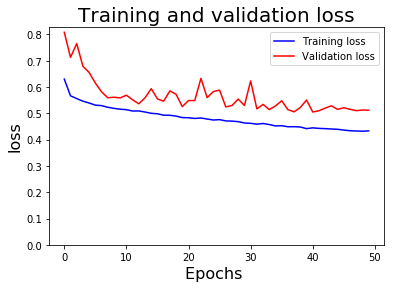

In [0]:
plot_validation_training("loss", trained_model)

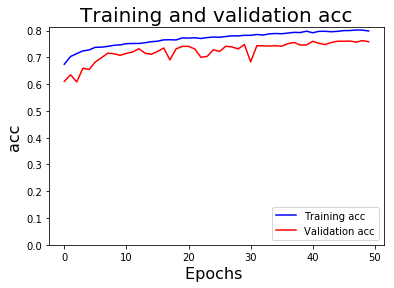

In [0]:
plot_validation_training("acc", trained_model)

In [0]:
model.load_weights("epoch=49_accuracy=0.8018_val_accuracy=0.7629.h5")

In [0]:
def get_activation_map(image_path, image_class_vector):        
        image_loaded = PIL.Image.open(image_path)
        image_loaded = image_loaded.resize((img_size, img_size))
        image_loaded = np.asarray(image_loaded)
      
        if len(image_loaded.shape) < 3:
          image_loaded = np.stack([image_loaded.copy()] * 3, axis=2)
        
        preprocessed_image = preprocess_input(image_loaded)
        preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
        
        image_class = np.argmax(image_class_vector)

        class_weights = model.layers[-1].get_weights()[0]
        final_conv_layer = model.layers[-3]
        
        get_output = tf.keras.backend.function([model.layers[0].input], 
                                               [final_conv_layer.output, model.layers[-1].output])
        
        [conv_outputs, predictions] = get_output(preprocessed_image)
        conv_outputs = conv_outputs[0, :, :, :]

        cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])

        for index, weight in enumerate(class_weights[:, image_class]):
          cam += weight * conv_outputs[:, :, index]
        
        class_predicted = np.argmax(predictions[0])
        predictions = f'Class predicted: {class_predicted} | Real class: {image_class}'
        
        cam /= np.max(cam)
        cam = cv2.resize(cam, (img_size, img_size))
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam < 0.2)] = 0
        
        img = heatmap * 0.5 + image_loaded
        cv2.imwrite("heatmap.jpg", img)
        
        heatmap = mpimg.imread("heatmap.jpg")
        
        scaled_image = (((img - img.min()) * 255) / (img.max() - img.min())).astype(np.uint8)
        
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].imshow(image_loaded)

        ax[0].set_title('Original image')

        ax[1].imshow(heatmap)
        ax[1].set_title(predictions)

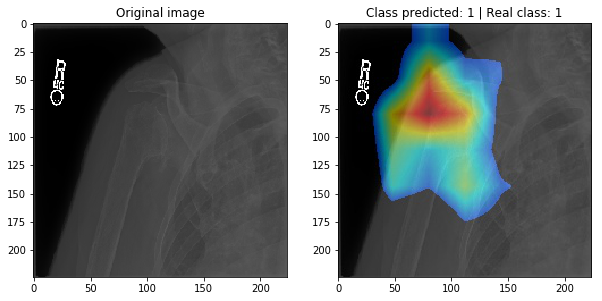

In [63]:
get_activation_map(X_train[2], y_train[2])

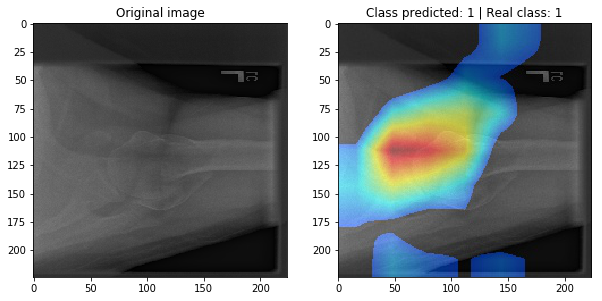

In [68]:
get_activation_map(X_train[30], y_train[30])

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
train_predict_generator = DataGenerator(X_train, y_train, batch_size, predict=True, shuffle=False)
val_predict_generator = DataGenerator(X_val, y_val, batch_size, predict=True, shuffle=False)

In [71]:
train_predictions = model.predict_generator(train_predict_generator, steps=train_steps, verbose=1)

1150/1150 [==============================] - 423s 368ms/step


In [72]:
len(train_predictions), len(y_train)

(36800, 36807)

In [0]:
predicted_classes = np.argmax(train_predictions, axis=1)
real_classes = np.argmax(y_train[:36800], axis=1)

In [74]:
len(predicted_classes), len(real_classes)

(36800, 36800)

In [75]:
np.count_nonzero(real_classes)

14872

In [76]:
np.count_nonzero(predicted_classes)

11525

In [77]:
X_train[0], y_train[0]

('MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png',
 array([0., 1.], dtype=float32))

In [0]:
classes_names = ["Normal", "Abnormal"]

Confusion matrix, without normalization


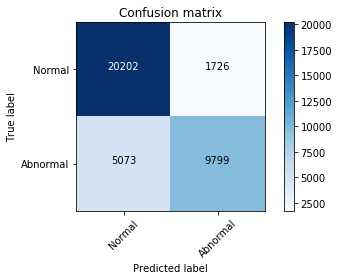

In [79]:
cm = confusion_matrix(real_classes, predicted_classes, labels=range(2))
plot_confusion_matrix(cm, classes_names)

In [0]:
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
print(f'sensitivity: {sensitivity}')

specificity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
print(f'specificity: {specificity}')

sensitivity: 0.9838562568405691
specificity: 0.9776089295320065


In [0]:
incorrect_labels = np.where(predicted_classes != real_classes)[0]

In [0]:
print(f"Found {len(incorrect_labels)} incorrect labels")

Found 687 incorrect labels


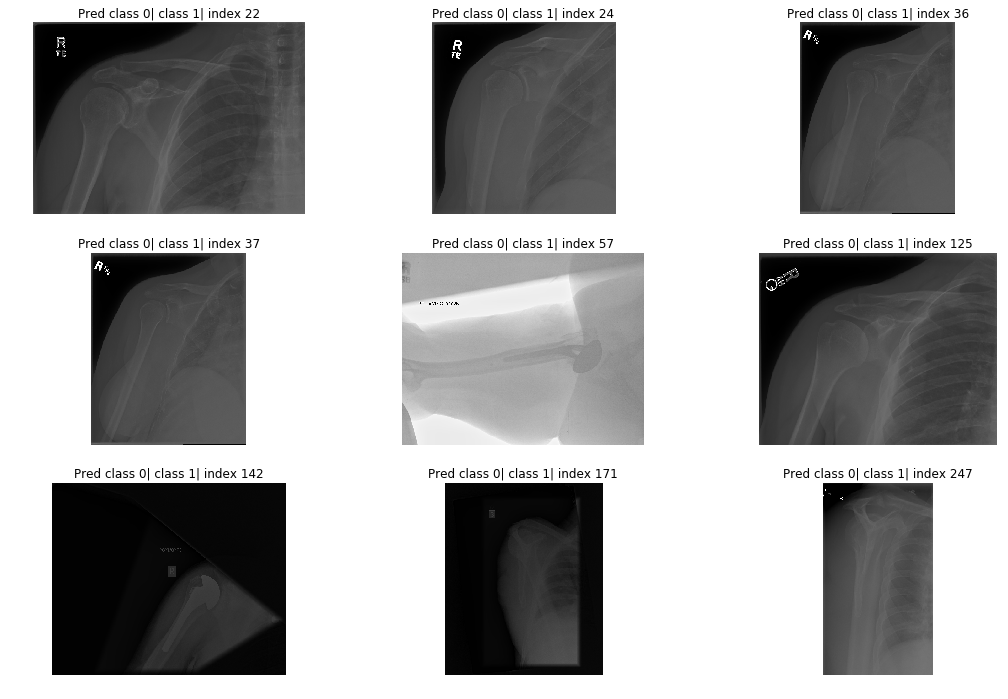

In [0]:
figure = plt.figure(figsize=(18, 12))

for index, incorrect_label_index in enumerate(incorrect_labels[:9]):
    sp = figure.add_subplot(3, 3, index + 1)
    sp.axis('Off')
    
    image_loaded = PIL.Image.open(X_train[incorrect_label_index])
    image_loaded = np.asarray(image_loaded)
    
    if len(image_loaded.shape) < 3:
      image_loaded = np.stack([image_loaded.copy()] * 3, axis=2)
      
    title = "Pred class {}| class {}| index {}".format(predicted_classes[incorrect_label_index], real_classes[incorrect_label_index], incorrect_label_index)
    
    sp.set_title(title, fontsize=12)
    plt.imshow(image_loaded, interpolation=None)

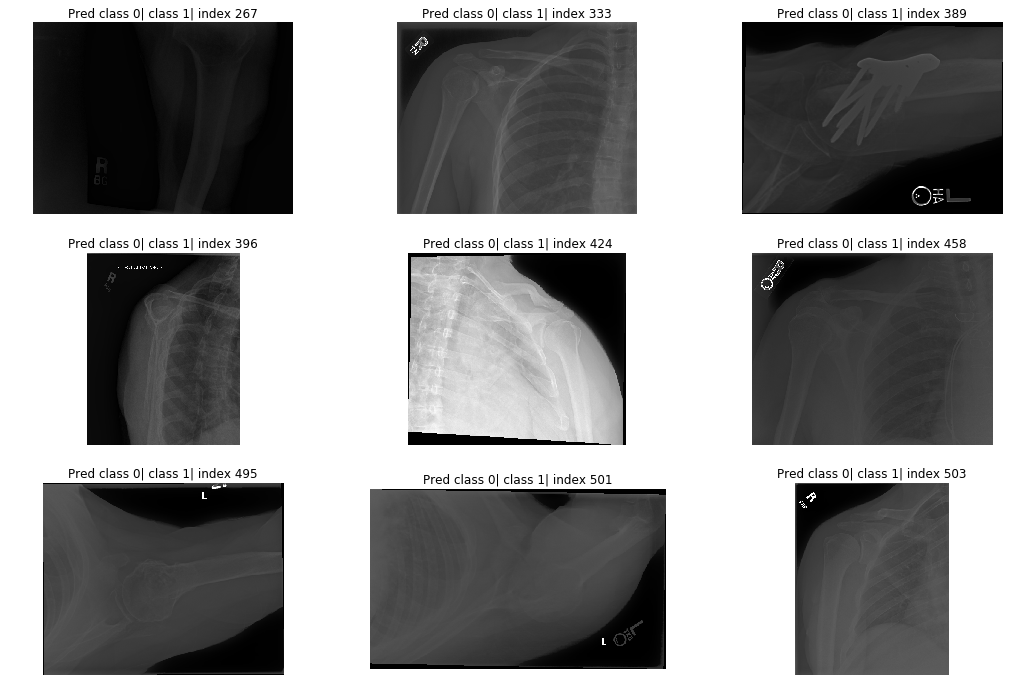

In [0]:
figure = plt.figure(figsize=(18, 12))

for index, incorrect_label_index in enumerate(incorrect_labels[9:18]):
    sp = figure.add_subplot(3, 3, index + 1)
    sp.axis('Off')
    
    image_loaded = PIL.Image.open(X_train[incorrect_label_index])
    image_loaded = np.asarray(image_loaded)
    
    if len(image_loaded.shape) < 3:
      image_loaded = np.stack([image_loaded.copy()] * 3, axis=2)
      
    title = "Pred class {}| class {}| index {}".format(predicted_classes[incorrect_label_index], real_classes[incorrect_label_index], incorrect_label_index)
    
    sp.set_title(title, fontsize=12)
    plt.imshow(image_loaded, interpolation=None)

In [0]:
train_incorrect_table = training_information.iloc[incorrect_labels]

In [0]:
train_incorrect_table["class"].size

687

In [0]:
train_incorrect_table.groupby("category").size()

category
XR_ELBOW       107
XR_FINGER       58
XR_FOREARM      20
XR_HAND        137
XR_HUMERUS      34
XR_SHOULDER    234
XR_WRIST        97
dtype: int64

## Validation set predictions

In [0]:
val_predictions = model.predict_generator(val_predict_generator, steps=val_steps, verbose=1)

99/99 [==============================] - 17s 171ms/step


In [0]:
len(val_predictions), len(y_val)

(3168, 3196)

In [0]:
val_predicted_classes = np.argmax(val_predictions, axis=1)
val_real_classes = np.argmax(y_val[:3168], axis=1)

In [0]:
X_val[0], y_val[0]

('MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png',
 array([0., 1.], dtype=float32))

Confusion matrix, without normalization


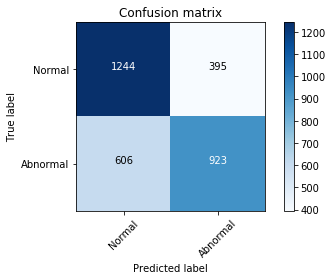

In [0]:
cm = confusion_matrix(val_real_classes, val_predicted_classes, labels=range(2))
plot_confusion_matrix(cm, classes_names)

In [0]:
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
print(f'sensitivity: {sensitivity}')

specificity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
print(f'specificity: {specificity}')

sensitivity: 0.7589993898718731
specificity: 0.6036625245258339


In [0]:
np.count_nonzero(val_predicted_classes)

1318

# Incorrect labels

In [0]:
val_incorrect_labels = np.where(val_predicted_classes != val_real_classes)[0]

In [0]:
print(f"Found {len(val_incorrect_labels)} incorrect labels")

Found 1001 incorrect labels


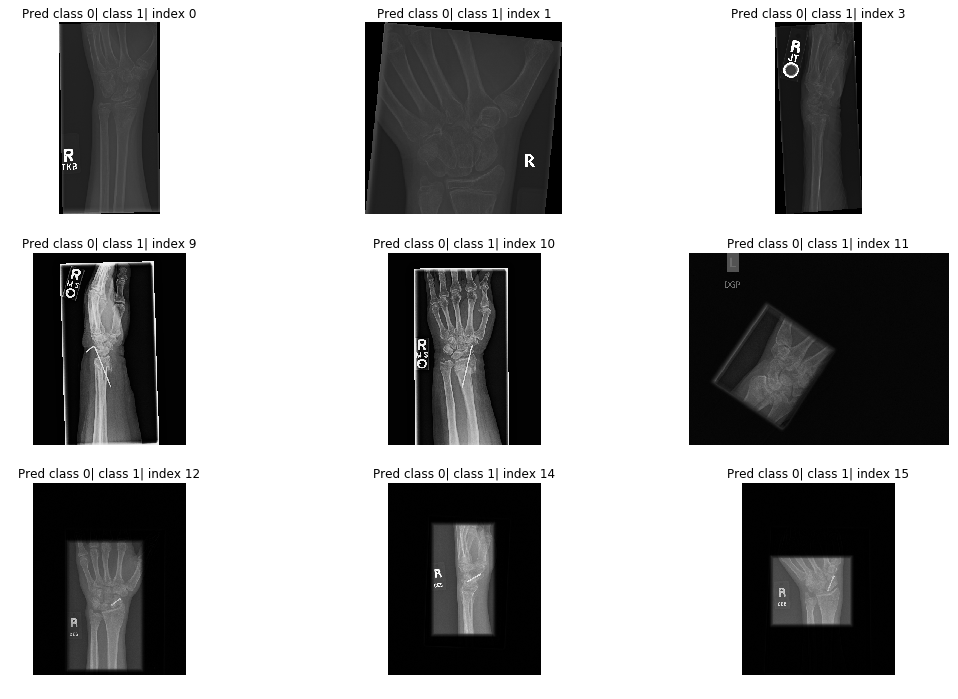

In [0]:
figure = plt.figure(figsize=(18, 12))

for index, incorrect_label_index in enumerate(val_incorrect_labels[:9]):
    sp = figure.add_subplot(3, 3, index + 1)
    sp.axis('Off')
    
    image_loaded = PIL.Image.open(X_val[incorrect_label_index])
    image_loaded = np.asarray(image_loaded)
    
    if len(image_loaded.shape) < 3:
      image_loaded = np.stack([image_loaded.copy()] * 3, axis=2)
      
    title = "Pred class {}| class {}| index {}".format(val_predicted_classes[incorrect_label_index], val_real_classes[incorrect_label_index], incorrect_label_index)
    
    sp.set_title(title, fontsize=12)
    plt.imshow(image_loaded, interpolation=None)

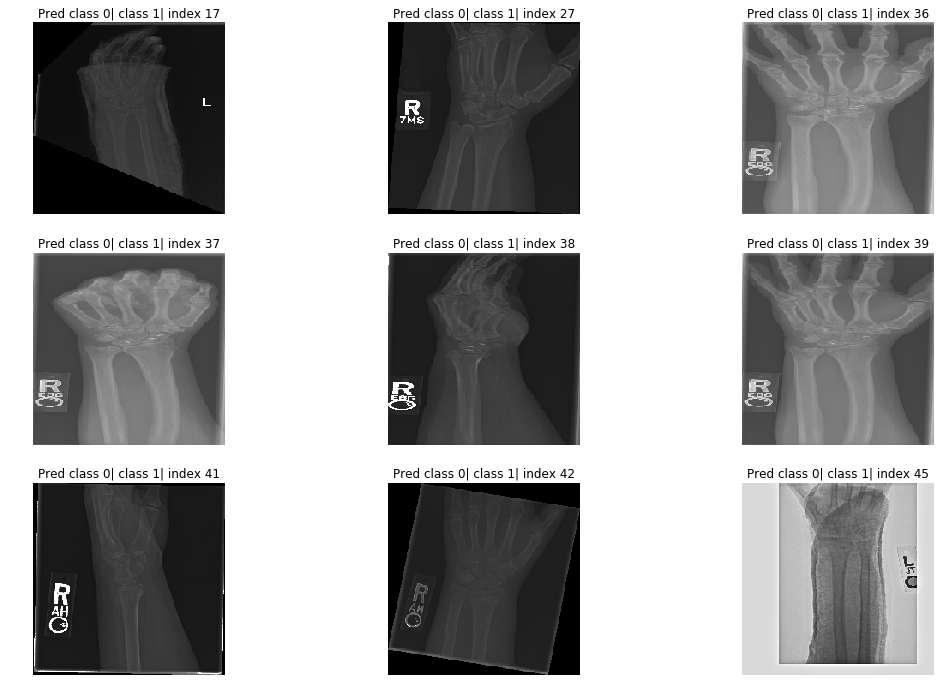

In [0]:
figure = plt.figure(figsize=(18, 12))

for index, incorrect_label_index in enumerate(val_incorrect_labels[9:18]):
    sp = figure.add_subplot(3, 3, index + 1)
    sp.axis('Off')
    
    image_loaded = PIL.Image.open(X_val[incorrect_label_index])
    image_loaded = image_loaded.resize((224, 224))
    image_loaded = np.asarray(image_loaded)
    
    if len(image_loaded.shape) < 3:
      image_loaded = np.stack([image_loaded.copy()] * 3, axis=2)
      
    title = "Pred class {}| class {}| index {}".format(val_predicted_classes[incorrect_label_index], val_real_classes[incorrect_label_index], incorrect_label_index)
    
    sp.set_title(title, fontsize=12)
    plt.imshow(image_loaded, interpolation=None)

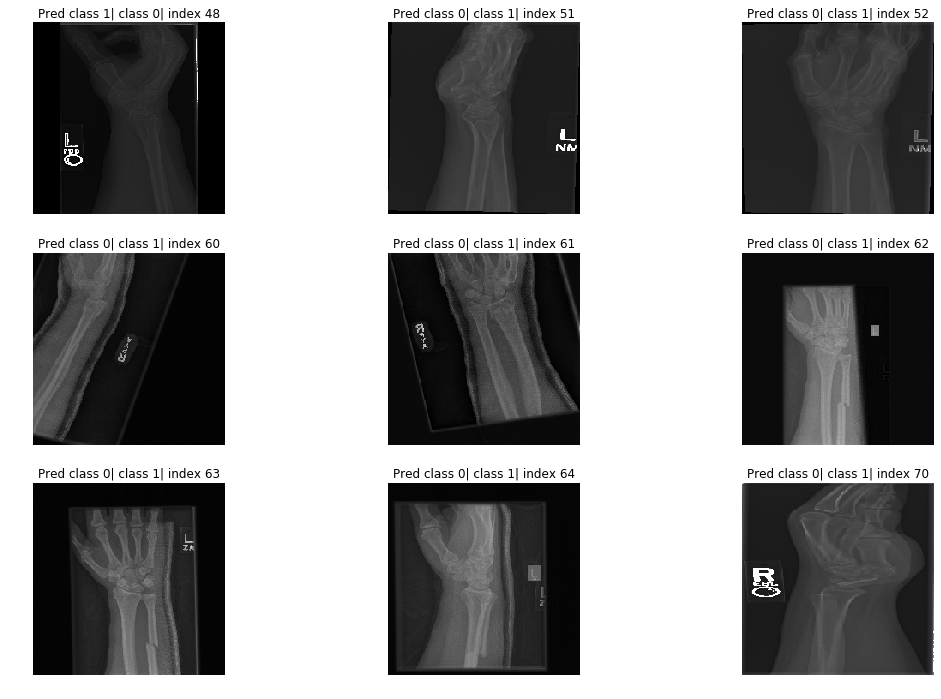

In [0]:
figure = plt.figure(figsize=(18, 12))

for index, incorrect_label_index in enumerate(val_incorrect_labels[18:27]):
    sp = figure.add_subplot(3, 3, index + 1)
    sp.axis('Off')
    
    image_loaded = PIL.Image.open(X_val[incorrect_label_index])
    image_loaded = image_loaded.resize((224, 224))
    image_loaded = np.asarray(image_loaded)
    
    if len(image_loaded.shape) < 3:
      image_loaded = np.stack([image_loaded.copy()] * 3, axis=2)
      
    title = "Pred class {}| class {}| index {}".format(val_predicted_classes[incorrect_label_index], val_real_classes[incorrect_label_index], incorrect_label_index)
    
    sp.set_title(title, fontsize=12)
    plt.imshow(image_loaded, interpolation=None)

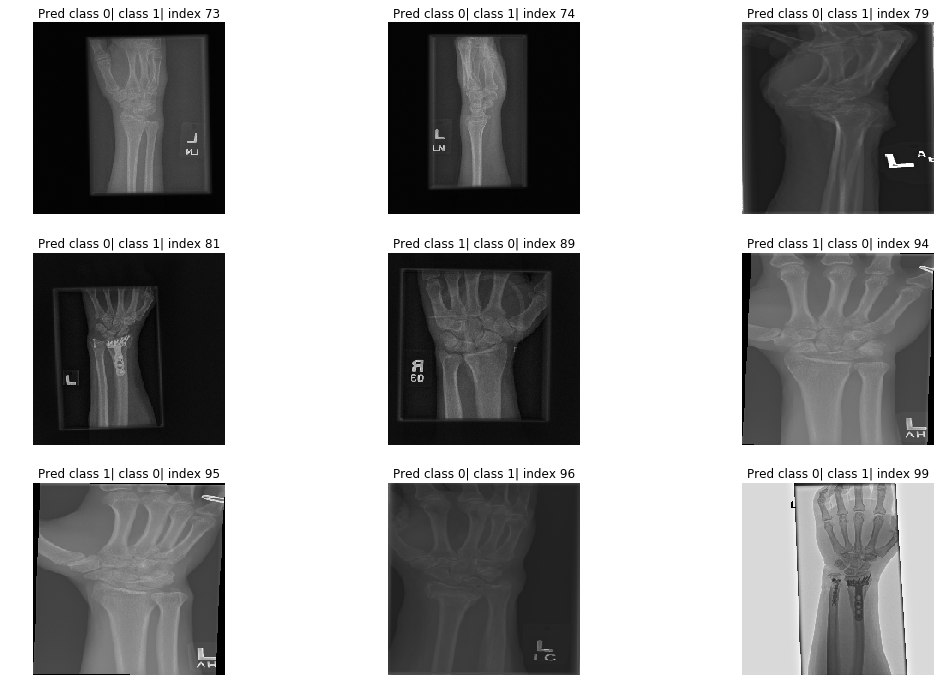

In [0]:
figure = plt.figure(figsize=(18, 12))

for index, incorrect_label_index in enumerate(val_incorrect_labels[27:36]):
    sp = figure.add_subplot(3, 3, index + 1)
    sp.axis('Off')
    
    image_loaded = PIL.Image.open(X_val[incorrect_label_index])
    image_loaded = image_loaded.resize((224, 224))
    image_loaded = np.asarray(image_loaded)
    
    if len(image_loaded.shape) < 3:
      image_loaded = np.stack([image_loaded.copy()] * 3, axis=2)
      
    title = "Pred class {}| class {}| index {}".format(val_predicted_classes[incorrect_label_index], val_real_classes[incorrect_label_index], incorrect_label_index)
    
    sp.set_title(title, fontsize=12)
    plt.imshow(image_loaded, interpolation=None)

In [0]:
valid_incorrect_table = valid_information.iloc[val_incorrect_labels]

In [0]:
valid_incorrect_table.head()

,Unnamed: 0,path,class,category
0,0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST
1,1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST
3,3,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,positive,XR_WRIST
9,9,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,positive,XR_WRIST
10,10,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,positive,XR_WRIST


In [0]:
valid_incorrect_table["class"].size

1001

In [0]:
valid_incorrect_table.groupby("category").size()

category
XR_ELBOW       143
XR_FINGER      141
XR_FOREARM      97
XR_HAND        152
XR_HUMERUS      85
XR_SHOULDER    201
XR_WRIST       182
dtype: int64

In [0]:
valid_incorrect_table.iloc[74]

Unnamed: 0                                                  229
path          MURA-v1.1/valid/XR_WRIST/patient11249/study1_p...
class                                                  positive
category                                               XR_WRIST
Name: 229, dtype: object